<a href="https://colab.research.google.com/github/pea2/CSCE623-Project/blob/main/sentiment_v18_video_rerun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Source

https://www.kaggle.com/kritanjalijain/twitter-sentiment-analysis/notebook

https://www.kaggle.com/smitshah00/sentiment-analysis-ml-rnn

https://www.kaggle.com/lykin22/twitter-sentiment-analysis-with-naive-bayes-85-acc

Data Source

https://www.kaggle.com/kazanova/sentiment140



In [ ]:
import sklearn
print(sklearn.__version__)
!pip install scikit-learn --upgrade
print(sklearn.__version__)

In [1]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


Set current working directory to Google Drive 

In [1]:
# set current working directory to Google Drive to retrive data
from google.colab import drive 
drive.mount('/content/drive')
import os
%cd /content/drive/My\ Drive/Colab\ Notebooks/Thesis/
os.getcwd()

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Thesis


'/content/drive/My Drive/Colab Notebooks/Thesis'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# Read in data

In [3]:
import pandas as pd
data = pd.read_csv('02 1.6 mil sentiment(neg pos).csv', encoding = 'latin', header=None)

# Data exploration in version 9

# Text preprocessing -- 10 min run

In [4]:
# rename columns
data = data.rename(columns={0: 'target', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'text'})
#  replace class 4 with 1 (for positive)
data['target'] = data['target'].replace({4:1})
# remove noisy columns
data.drop(['id','date','query','username'], axis=1, inplace=True)
print(data.columns)
data['target'].unique()

Index(['target', 'text'], dtype='object')


array([0, 1])

## Emoji, smiley, contraction, cleaning preprocessing

### functions to clean text - Add new column to the data called "clean" -- 2 min run

In [5]:
import re

################################################################################
################################################################################
def replace_emojis(t):
    '''
    This function replaces happy unicode emojis with "happy" and sad unicode emojis with "sad"
    '''
    emoji_happy = ["\U0001F600", "\U0001F601", "\U0001F602","\U0001F603","\U0001F604","\U0001F605", "\U0001F606", "\U0001F607", "\U0001F609", 
                  "\U0001F60A", "\U0001F642","\U0001F643","\U0001F923",r"\U0001F970","\U0001F60D", r"\U0001F929","\U0001F618","\U0001F617",
                  r"\U000263A", "\U0001F61A", "\U0001F619", r"\U0001F972", "\U0001F60B", "\U0001F61B", "\U0001F61C", r"\U0001F92A",
                  "\U0001F61D", "\U0001F911", "\U0001F917", r"\U0001F92D", r"\U0001F92B","\U0001F914","\U0001F910", r"\U0001F928", "\U0001F610", "\U0001F611",
                  "\U0001F636", "\U0001F60F","\U0001F612", "\U0001F644","\U0001F62C","\U0001F925","\U0001F60C","\U0001F614","\U0001F62A",
                  "\U0001F924","\U0001F634", "\U0001F920", r"\U0001F973", r"\U0001F978","\U0001F60E","\U0001F913", r"\U0001F9D0"]

    emoji_sad = ["\U0001F637","\U0001F912","\U0001F915","\U0001F922", r"\U0001F92E","\U0001F927", r"\U0001F975", r"\U0001F976", r"\U0001F974",
                  "\U0001F635", r"\U0001F92F", "\U0001F615","\U0001F61F","\U0001F641", r"\U0002639","\U0001F62E","\U0001F62F","\U0001F632",
                  "\U0001F633", r"\U0001F97A","\U0001F626","\U0001F627","\U0001F628","\U0001F630","\U0001F625","\U0001F622","\U0001F62D",
                  "\U0001F631","\U0001F616","\U0001F623"	,"\U0001F61E","\U0001F613","\U0001F629","\U0001F62B", r"\U0001F971",
                  "\U0001F624","\U0001F621","\U0001F620", r"\U0001F92C","\U0001F608","\U0001F47F","\U0001F480", r"\U0002620"]

    words = t.split()
    reformed = []
    for w in words:
        if w in emoji_happy:
            reformed.append("happy")
        elif w in emoji_sad:
            reformed.append("sad") 
        else:
            reformed.append(w)
    t = " ".join(reformed)
    return t
################################################################################
################################################################################
def replace_smileys(t):
    '''
    This function replaces happy smileys with "happy" and sad smileys with "sad"
    '''
    emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':D',
      ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
      '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
      'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'])

    emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
      ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
      ':c', ':{', '>:\\', ';('])  

    words = t.split()
    reformed = []
    for w in words:
        if w in emoticons_happy:
            reformed.append("happy")
        elif w in emoticons_sad:
            reformed.append("sad") 
        else:
            reformed.append(w)
    t = " ".join(reformed)
    return t
################################################################################
################################################################################
def replace_contractions(t):
    '''
    This function replaces english lanuage contractions, eg., "shouldn't" with "should not"
    '''
    cont = {"aren't" : 'are not', "can't" : 'cannot', "couln't": 'could not', "didn't": 'did not', "doesn't" : 'does not',
    "hadn't": 'had not', "haven't": 'have not', "he's" : 'he is', "she's" : 'she is', "he'll" : "he will", 
    "she'll" : 'she will',"he'd": "he would", "she'd":"she would", "here's" : "here is", 
    "i'm" : 'i am', "i've"	: "i have", "i'll" : "i will", "i'd" : "i would", "isn't": "is not", 
    "it's" : "it is", "it'll": "it will", "mustn't" : "must not", "shouldn't" : "should not", "that's" : "that is", 
    "there's" : "there is", "they're" : "they are", "they've" : "they have", "they'll" : "they will",
    "they'd" : "they would", "wasn't" : "was not", "we're": "we are", "we've":"we have", "we'll": "we will", 
    "we'd" : "we would", "weren't" : "were not", "what's" : "what is", "where's" : "where is", "who's": "who is",
    "who'll" :"who will", "won't":"will not", "wouldn't" : "would not", "you're": "you are", "you've":"you have",
    "you'll" : "you will", "you'd" : "you would", "mayn't" : "may not"}
    
    words = t.split()
    reformed = []
    for w in words:
        if w in cont:
          reformed.append(cont[w])
        else:
          reformed.append(w)
    t = " ".join(reformed)
    return t  
################################################################################
################################################################################
def remove_single_letter_words(t):
    '''
    This function removes words that are single characters
    '''
    words = t.split()
    reformed = []
    for w in words:
        if len(w) > 1:
            reformed.append(w)
    t = " ".join(reformed)
    return t 
################################################################################
################################################################################

# define emojis
emoji_pattern = re.compile("["
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def clean_data(t):
    '''
    This function cleans the tweets
    '''
    t = t.lower() # convert to lowercase
    t = replace_emojis(t) # replace unicode emojis with their associated emotions
    t = replace_smileys(t) # replace handwritten emojis with their associated emotions
    t = replace_contractions(t) # replace English short forms with their long form
    t = emoji_pattern.sub(r'', t) # remove emojis other than smiley emojis
    t = re.sub('\\\\u[0-9A-Fa-f]{4}','', t) # remove NON- ASCII characters
    t = re.sub("[0-9]", "", t) # remove numbers # re.sub("\d+", "", t)
    t = re.sub('#', '', t) # remove '#'
    t = re.sub('@[A-Za-z0–9]+', '', t) # remove '@'
    t = re.sub('@[^\s]+', '', t) # remove usernames
    t = re.sub('RT[\s]+', '', t) # remove retweet 'RT'
    t = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', t) # remove links (URLs/ links)
    t = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', ' ', t)  ## replace punctuations with space ###
    t = t.replace('\\\\', '')
    t = t.replace('\\', '')
    t = remove_single_letter_words(t) # removes single letter words
    t = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(t).lower()).strip() # remove mentions and links in tweets
    
    return t
################################################################################
################################################################################

Add new column to the data called "clean"

In [6]:
print("Cleaning tweets...\n")
print("Convert to lowercase")
print("Replace unicode emojis with their associated emotions")
print("Replace handwritten emojis with their associated emotions")
print("Replace English short forms with their long form")
print("Remove all other unicoded emojis")
print("Remove NON- ASCII characters")
print("Remove numbers")
print("Remove \"#\" ")
print("Remove \"@\" ")
print("Remove usernames")
print("Remove \'RT\' ")
print("Remove URLs and links")
print("Replace punctuations with space")
print("Remove single letter words")
print("Remove mentions and links in tweets\n")

data['clean'] = data['text'].apply(clean_data)
print("Tweets have been cleaned.")

Cleaning tweets...

Convert to lowercase
Replace unicode emojis with their associated emotions
Replace handwritten emojis with their associated emotions
Replace English short forms with their long form
Remove all other unicoded emojis
Remove NON- ASCII characters
Remove numbers
Remove "#" 
Remove "@" 
Remove usernames
Remove 'RT' 
Remove URLs and links
Replace punctuations with space
Remove single letter words
Remove mentions and links in tweets

Tweets have been cleaned.


### Text normalization - Add new column to the data called "normal" -- 9 min run

In [7]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk_stopwords = nltk.corpus.stopwords.words('english')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
nltk.download('wordnet')
wnl = nltk.WordNetLemmatizer()
porter = nltk.PorterStemmer()

def normalize_data(doc):
  
  # tokenize text
  doc = nltk.tokenize.word_tokenize(doc)

  # remove stops words
  doc = [ w for w in doc if w not in (nltk_stopwords and sklearn_stopwords) ]

  # lemmatization
  doc = [wnl.lemmatize(w) for w in doc]

  # stemming
  doc = [porter.stem(w) for w in doc]

  # remove single letter
  doc = [w for w in doc if len(w)>1]

  return ' '.join(doc)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Add new column to the data called "normal"

In [8]:
#  8 minutes 15 seconds
data['normal'] = data['clean'].apply(normalize_data)

# Normalized Text Output

In [9]:
pd.set_option('display.max_colwidth', None)
data.head()

,target,text,clean,normal
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww that is bummer you shoulda got david carr of third day to do it,awww bummer shoulda got david carr day
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as result school today also blah,upset updat facebook text result school today blah
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived many times for the ball managed to save the rest go out of bounds,dive time ball manag save rest bound
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,bodi feel itchi like
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",no it is not behaving at all am mad why am here because cannot see you all over there,behav mad


# Split train test data 80% 20%

In [10]:
from sklearn.model_selection import train_test_split

X = data['normal']
y = data['target']

# train-test split: 80-20
random_state = 9363

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.20, 
                                                    random_state=random_state, 
                                                    stratify = y)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape:  ', X_test.shape)
print('y_test.shape:  ', y_test.shape)
print('\ntraining set target counts per class:\n', y_train.value_counts(), '\n')
print('test set target counts per class:\n', y_test.value_counts())

X_train.shape:  (1280000,)
y_train.shape:  (1280000,)
X_test.shape:   (320000,)
y_test.shape:   (320000,)

training set target counts per class:
 1    640000
0    640000
Name: target, dtype: int64 

test set target counts per class:
 1    160000
0    160000
Name: target, dtype: int64


# Hyperparameter tuning in Copy of sentiment-test

# Convert text to word frequency vectors
Feature extraction via TF-IDF Vectorizor

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Convert a collection of raw documents to a matrix of TF-IDF features.

vector = TfidfVectorizer(max_features=20000, sublinear_tf=True)
vector.fit(X_train)
print('No. of feature_words: ', len(vector.get_feature_names()))

# Transforming the X_train and X_test dataset into matrix of TF-IDF Features 
# by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.
X_train = vector.transform(X_train)
X_test = vector.transform(X_test)

# https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners

No. of feature_words:  20000


# Model testing

### fit model, plot confusion matrix, roc curve

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve

def evaluate(model, X_train, y_train, X_test, y_test, title):
    """ evaluate model and report test set performance in confusion matrix and precision, recall, f1, support
    """
    # fit model
    model.fit(X_train, y_train)

    # accuracy of model on training data
    acc_train = model.score(X_train, y_train)
    # accuracy of model on test set
    acc_test = model.score(X_test, y_test)
    
    print('Accuracy of '+ title +' model on training set : {}'.format(acc_train*100))
    print('Accuracy of '+ title +' model on test set : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix for " + title, fontdict = {'size':16}, pad = 20)
    plt.show()

    print('\n') 

    roc = plot_roc_curve(model, X_test, y_test)
    plt.title('ROC Curve for ' + title)
    plt.show()

    return y_pred, roc

### Logistic Regression -- 46 min run

Accuracy of Logistic Regression model on training set : 77.64578125
Accuracy of Logistic Regression model on test set : 76.955 

              precision    recall  f1-score   support

           0       0.78      0.74      0.76    160000
           1       0.76      0.80      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



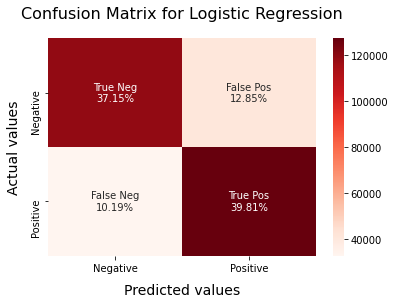

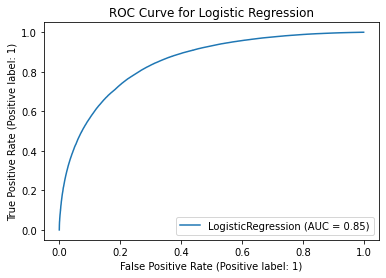

In [14]:
from sklearn.linear_model import LogisticRegression
# preset logreg parameters
max_iter = 100000
penalty = 'elasticnet'
l1_ratio = 0.8
c = 0.7
solver = 'saga' # for larger dataset, faster, also supports elasticnet penalty in addition to ridge and lasso
logistic_regression = LogisticRegression(max_iter=max_iter,penalty=penalty, l1_ratio=l1_ratio, C=c, solver=solver)
y_pred_logreg, roc_logreg = evaluate(logistic_regression, X_train, y_train, X_test, y_test, 'Logistic Regression')

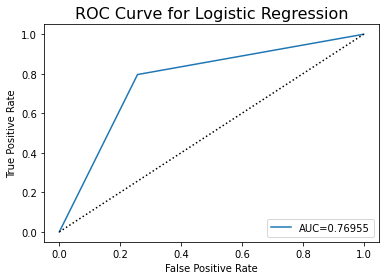

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_logreg)
auc = metrics.roc_auc_score(y_test, y_pred_logreg)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# plot no skill line
plt.plot([0,1], [0,1], ':k')
plt.title('ROC Curve for Logistic Regression', fontsize=16)
plt.show()

# https://www.statology.org/plot-roc-curve-python/

### SVC Linear Kernel -- 30 sec run

Accuracy of SVC model on training set : 77.739453125
Accuracy of SVC model on test set : 76.749375 

              precision    recall  f1-score   support

           0       0.78      0.74      0.76    160000
           1       0.75      0.79      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



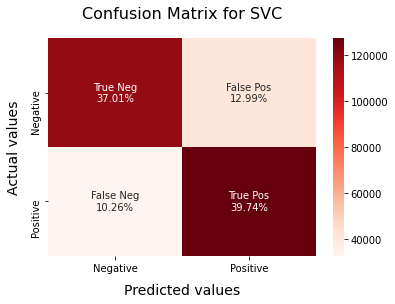

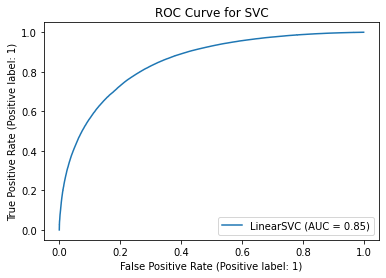

In [16]:
from sklearn.svm import LinearSVC
svc_linear = LinearSVC(C=0.3)
y_pred_svc, roc_svc = evaluate(svc_linear, X_train, y_train, X_test, y_test, 'SVC')

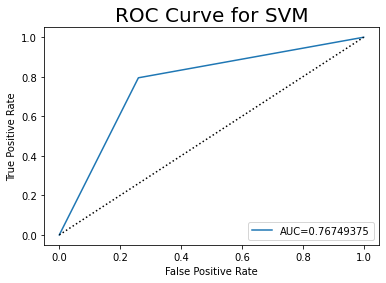

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_svc)
auc = metrics.roc_auc_score(y_test, y_pred_svc)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# plot no skill line
plt.plot([0,1], [0,1], ':k')
plt.title('ROC Curve for SVM', fontsize=20)
plt.show()

# https://www.statology.org/plot-roc-curve-python/

### Naive Bayes Bernoulli -- 1 sec run

Accuracy of NB model on training set : 76.69796875
Accuracy of NB model on test set : 76.2109375 

              precision    recall  f1-score   support

           0       0.77      0.75      0.76    160000
           1       0.75      0.78      0.77    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



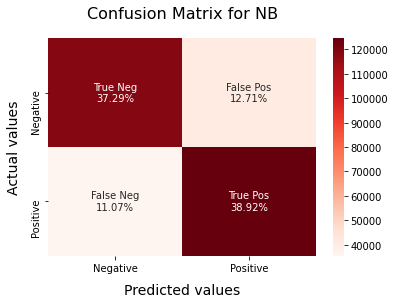

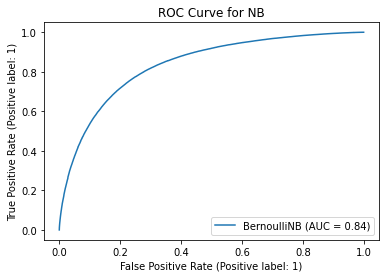

In [18]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
y_pred_nb, roc_nb = evaluate(nb, X_train, y_train, X_test, y_test,'NB')

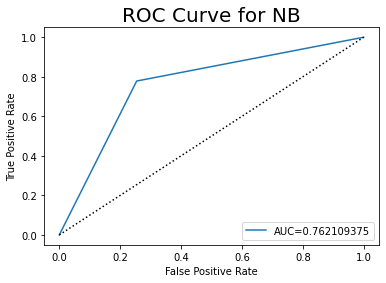

In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nb)
auc = metrics.roc_auc_score(y_test, y_pred_nb)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# plot no skill line
plt.plot([0,1], [0,1], ':k')
plt.title('ROC Curve for NB', fontsize=20)
plt.show()

# https://www.statology.org/plot-roc-curve-python/

### Naive Bayes Multinomial -- 1 sec run

Accuracy of NB Multi model on training set : 76.116484375
Accuracy of NB Multi model on test set : 75.35531250000001 

              precision    recall  f1-score   support

           0       0.75      0.75      0.75    160000
           1       0.75      0.76      0.75    160000

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



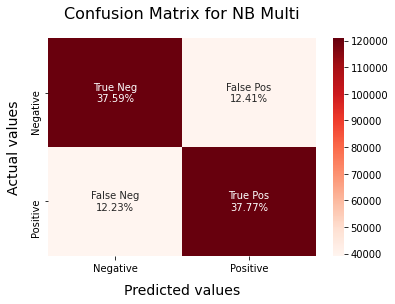

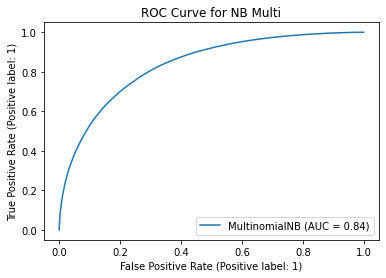

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb_mul = MultinomialNB()
y_pred_nb_mul, roc_nb_mul = evaluate(nb_mul, X_train, y_train, X_test, y_test,'NB Multi')

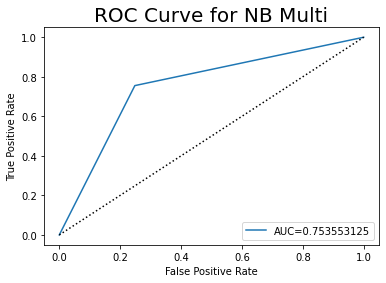

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nb_mul)
auc = metrics.roc_auc_score(y_test, y_pred_nb_mul)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# plot no skill line
plt.plot([0,1], [0,1], ':k')
plt.title('ROC Curve for NB Multi', fontsize=20)
plt.show()

# https://www.statology.org/plot-roc-curve-python/

### LDA

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda = LinearDiscriminantAnalysis()
# # y_pred_lda = evaluate(lda, X_train.toarray(), y_train, X_test.toarray(), y_test,'LDA')

### QDA

In [ ]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# qda = QuadraticDiscriminantAnalysis()
# y_pred_qda = evaluate(qda, X_train, y_train, X_test, y_test,'QDA')

# Error Analysis

In [22]:
# grab row index that are test data
index = y_test.index

# make a dataframe for each classifier using the index 
logreg_df = pd.DataFrame(y_pred_logreg, index=index).rename(columns={0:'logreg'})
svc_df = pd.DataFrame(y_pred_svc, index=index).rename(columns={0:'svc'})
nb_df = pd.DataFrame(y_pred_nb, index=index).rename(columns={0:'nb'})

# create a dataframe for the test set with original tweet, cleaned and normalized tweet
test_df = pd.DataFrame(data['text'], index=index).join(pd.DataFrame(data['clean'], index=index)).join(pd.DataFrame(data['normal'], index=index)).join(y_test)

# create a dataframe joining the test data and the classifiers predictions
pred_df = test_df.join([logreg_df, svc_df, nb_df])

# save result to a csv so that I don't have to run 30 minutes of the program to regenrate the result, result saved to Google Drive
pred_df.to_csv('pred_df.csv')


## False Negative

In [23]:
# positive target
pos_df = pred_df[pred_df['target']==1]

### logreg fn

In [24]:
# 32578 (10.18%) test examples are misslabeld as negative by logreg, fn
fn_logreg = pos_df[pos_df['logreg']==0]
fn_logreg

,text,clean,normal,target,logreg,svc,nb
1451326,"feeling bored, but still in da good mood",feeling bored but still in da good mood,feel bore da good mood,1,0,0,0
1533606,I left my Flip camera at home so I hope @michele_perras comes to hear my talk so I have a witness to my presentation,left my flip camera at home so hope perras comes to hear my talk so have witness to my presentation,left flip camera home hope perra come hear talk wit present,1,0,0,0
1024637,I am not working very hard today! thinking about weekend,am not working very hard today thinking about weekend,work hard today think weekend,1,0,0,0
1275559,"I love the feeling of being hugged. So, will anyone, please, give me a hug today.",love the feeling of being hugged so will anyone please give me hug today,love feel hug hug today,1,0,0,0
1065444,"@verityh going to miss you at this impending ZOMGbash but appreciate your work ethic You go, Girl!",going to miss you at this impending zomgbash but appreciate your work ethic you go girl,go miss impend zomgbash appreci work ethic girl,1,0,0,0
...,...,...,...,...,...,...,...
1088109,Spoke too soon. Just had a phone call from a very out of breath @jagusti. What a guy,spoke too soon just had phone call from very out of breath what guy,spoke soon just phone breath guy,1,0,0,0
1026916,Is home!!,is home,home,1,0,0,0
1574484,@NixiePixel all because you were on digg... not bad.,all because you were on digg not bad,digg bad,1,0,0,0
1195876,@sheenaswu @kimberlaaaay Noo they're too expensive.,noo they are too expensive,noo expens,1,0,0,0


### svc fn

In [25]:
# 32854 (10.27%) test examples are misslabeld as negative by svc
fn_svc = pos_df[pos_df['svc']==0]
fn_svc

,text,clean,normal,target,logreg,svc,nb
1451326,"feeling bored, but still in da good mood",feeling bored but still in da good mood,feel bore da good mood,1,0,0,0
1527747,@RanRunsIt I do.. I must of missd that one..LOL.. Just bump that and dance yourself into a good mood..,do must of missd that one lol just bump that and dance yourself into good mood,missd lol just bump danc good mood,1,1,0,0
1533606,I left my Flip camera at home so I hope @michele_perras comes to hear my talk so I have a witness to my presentation,left my flip camera at home so hope perras comes to hear my talk so have witness to my presentation,left flip camera home hope perra come hear talk wit present,1,0,0,0
1291143,"FEZ, the SOUL of Morocco - Great weather; food, hospitality http://travel.nytimes.com/2007/04/08/travel/08Fez.html and they love Asians!",fez the soul of morocco great weather food hospitality and they love asians,fez soul morocco great weather food hospit love asian,1,1,0,1
1024637,I am not working very hard today! thinking about weekend,am not working very hard today thinking about weekend,work hard today think weekend,1,0,0,0
...,...,...,...,...,...,...,...
1026916,Is home!!,is home,home,1,0,0,0
1398540,@problemsolver22 thanks boo,thanks boo,thank boo,1,1,0,1
1574484,@NixiePixel all because you were on digg... not bad.,all because you were on digg not bad,digg bad,1,0,0,0
1195876,@sheenaswu @kimberlaaaay Noo they're too expensive.,noo they are too expensive,noo expens,1,0,0,0


### nb fn

In [26]:
# 35429 (11.07%) test examples are misslabeld as negative (fn) by nb
fn_nb = pos_df[pos_df['nb']==0]
fn_nb

,text,clean,normal,target,logreg,svc,nb
1451326,"feeling bored, but still in da good mood",feeling bored but still in da good mood,feel bore da good mood,1,0,0,0
1527747,@RanRunsIt I do.. I must of missd that one..LOL.. Just bump that and dance yourself into a good mood..,do must of missd that one lol just bump that and dance yourself into good mood,missd lol just bump danc good mood,1,1,0,0
1533606,I left my Flip camera at home so I hope @michele_perras comes to hear my talk so I have a witness to my presentation,left my flip camera at home so hope perras comes to hear my talk so have witness to my presentation,left flip camera home hope perra come hear talk wit present,1,0,0,0
1181823,Laying by the pool alllll day!,laying by the pool alllll day,lay pool alllll day,1,1,1,0
1024637,I am not working very hard today! thinking about weekend,am not working very hard today thinking about weekend,work hard today think weekend,1,0,0,0
...,...,...,...,...,...,...,...
1466332,In edinbugh shopping gotta love twitterberry. Hahahah. Gonna try + convince parents for muse tickets for november(;,in edinbugh shopping gotta love twitterberry hahahah gonna try convince parents for muse tickets for november,edinbugh shop got ta love twitterberri hahahah gon na tri convinc parent muse ticket novemb,1,1,1,0
1026916,Is home!!,is home,home,1,0,0,0
813450,Oh great. No a/c in the house. &amp; it won't be fixed until Monday :/ Mall tomorrow after work with the BFF!,oh great no in the house amp it will not be fixed until monday mall tomorrow after work with the bff,oh great hous amp fix monday mall tomorrow work bff,1,1,1,0
1574484,@NixiePixel all because you were on digg... not bad.,all because you were on digg not bad,digg bad,1,0,0,0


## fn

In [27]:
# all three classifiers predicts negative on a true positive, 
# 8.65% all three classifiers are wrong when predicting positive as negative
fn = fn_nb[fn_nb['svc']==0][fn_nb['logreg']==0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
fn[30:40]

,text,clean,normal,target,logreg,svc,nb
1512945,cutting up tshirts,cutting up tshirts,cut tshirt,1,0,0,0
903466,"so the Today show still hasn't gotten in touch with me, i wish they would so i can take my friends and myself to the NKOTB show",so the today show still hasn gotten in touch with me wish they would so can take my friends and myself to the nkotb show,today hasn gotten touch wish friend nkotb,1,0,0,0
1335579,i just got my @blink182 tickets sucks i could only presale 4 tickets,just got my tickets sucks could only presale tickets,just got ticket suck presal ticket,1,0,0,0
1044749,@taylorswift13 You don't need sleep! Live every moment (until you really need a nap!) Your voice is a gift and the show will be awesome!,you don need sleep live every moment until you really need nap your voice is gift and the show will be awesome,don need sleep live moment realli need nap voic gift awesom,1,0,0,0
1509536,im tired but i dont feel like going to bed but i will anyways. goodnight tweeters,im tired but dont feel like going to bed but will anyways goodnight tweeters,im tire dont feel like go bed anyway goodnight tweeter,1,0,0,0
1031994,"@mgehlers well MtL but yeah same same, different shaped ball causing the issue",well mtl but yeah same same different shaped ball causing the issue,mtl yeah differ shape ball caus issu,1,0,0,0
886308,@stephenaevans I want to wake up not get a migraine,want to wake up not get migraine,want wake migrain,1,0,0,0
1188702,@Dannymcfly Aww poor Harry! I look forward to him tweeting too,aww poor harry look forward to him tweeting too,aww poor harri look forward tweet,1,0,0,0
1150166,"Oh, Firefox, I've missed you in some ways. Like your Reload All Tabs option, or like the NoScript add-on. I don't mind Chrome 'sploding",oh firefox have missed you in some ways like your reload all tabs option or like the noscript add on don mind chrome sploding,oh firefox miss way like reload tab option like noscript add don mind chrome splode,1,0,0,0
1512235,"@cambie Totally. I was just pulling legs with that. So what, I lost 3 followers. Let it sink... I'll blow bubbles",totally was just pulling legs with that so what lost followers let it sink will blow bubbles,total just pull leg lost follow let sink blow bubbl,1,0,0,0


Since more than 8 and a half of the time, all three classifiers predictive a negative while the truth is positive, analyzie the text where all three got wrong.  

## False Positive

In [29]:
# negatie target
neg_df = pred_df[pred_df['target']==0]
# test examples are misslabeld as positive by logreg, fp
fp_logreg = neg_df[neg_df['logreg']==1]
fp_logreg
# test examples are misslabeld as positive by svc, fp
fp_svc = neg_df[neg_df['svc']==1]
fp_svc
# test examples are misslabeld as positive by nb, fp
fp_nb = neg_df[neg_df['nb']==1]
fp_nb
# all three classifiers predicts positive on a true negative, 
# all three classifiers are wrong when predicting negative as positive
fp = fp_nb[fp_nb['svc']==1][fp_nb['logreg']==1]
fp[6000:6020]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,text,clean,normal,target,logreg,svc,nb
599134,i 4got to watch boys over flowers...,got to watch boys over flowers,got watch boy flower,0,1,1,1
780336,@smileshutter Me too I'll go check it out,me too will go check it out,check,0,1,1,1
526283,@HankBobBBQ no curry in my pantry,no curry in my pantry,curri pantri,0,1,1,1
214233,can't go swimming 2 day..mabey tomorrow..,cannot go swimming day mabey tomorrow,swim day mabey tomorrow,0,1,1,1
672072,@dormicile okay. thanks though!,okay thanks though,okay thank,0,1,1,1
33990,Is it already weekend...?,is it already weekend,weekend,0,1,1,1
709435,@Dannymcfly http://twitpic.com/7xvhl - follow me follow me follow me follow me follow me follow me follow me follow ...,follow me follow me follow me follow me follow me follow me follow me follow,follow follow follow follow follow follow follow follow,0,1,1,1
155979,i feel so alone hehe...that's because i am.. haha..i wanna watch up,feel so alone hehe that because am haha wanna watch up,feel hehe haha wan na watch,0,1,1,1
61947,@definitelyian it was fun.. they were great! i didn't see you ..,it was fun they were great did not see you,fun great did,0,1,1,1
157273,"@missxena I just really love Exene and John Doe, I think Billy is still in the band . But Im not 21 so now I cant go to the shows",just really love exene and john doe think billy is still in the band but im not so now cant go to the shows,just realli love exen john doe think billi band im show,0,1,1,1
